In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib import patches
import pandas as pd

from astropy import table
from astropy.io import fits
from astropy import units as u
from astropy import coordinates, cosmology
from astropy import wcs

from astroquery.mast import Catalogs
from astroquery.skyview import SkyView
from astroquery.simbad import Simbad
from astroquery.ipac.ned import Ned
Simbad.add_votable_fields('z_value')

from ekfobs import planning
from ekfobs import observe as eo
from ekfphys import observer, calibrations
from ekfplot import plot as ek
from ekfstats import sampling
from ekfparse import query

from agrias import utils
from skipper import observe

import sys
sys.path.append('../scripts')
import reader

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [3]:
def fha_from_sfr ( sample, z=0.08):
    dlum = cosmo.luminosity_distance(z).to(u.cm).value
    return calibrations.SFR2LHa(10.**sample['logsfr']) / (4*np.pi*dlum**2)
    

In [6]:
ms = reader.merianselect ( )

[merianselect] Only choosing sources with m_i < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in

In [7]:
lha_cat = calibrations.SFR2LHa( 10.**(ms['logssfr']+ ms['logmass']))
fha_cat = lha_cat / (4.*np.pi * cosmo.luminosity_distance(ms['z500'].values).to(u.cm).value**2)

In [8]:
palomar = observe.ObservingSite('palomar')
lco = observe.ObservingSite('CTIO')

# EELG Selection

In [9]:
sample_name = 'highmass_EELGs'
if not os.path.exists(sample_name):
    os.mkdir(sample_name)

for dirname in  ['thumbnails','cutouts','finding_charts']:
    dpath = f'{sample_name}/{dirname}'
    if not os.path.exists(dpath):
        os.mkdir(dpath)

Text(0, 0.5, '$\\log_{10}({\\rm SFR}/[\\rm M_\\odot\\ {\\rm yr}^{-1}])$')

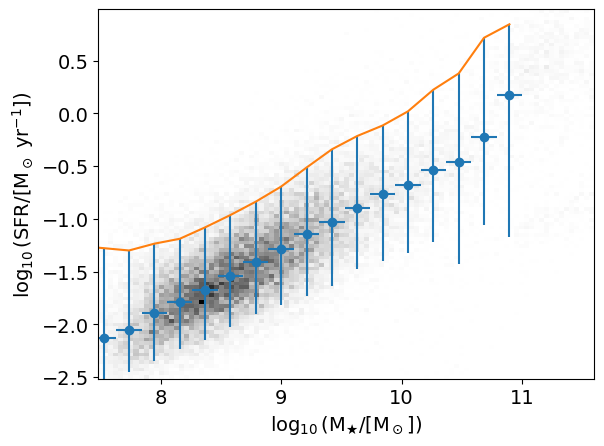

In [10]:
_=ek.hist2d(ms['logmass'], ms['logsfr'], bins=100)
midpts,qts=ek.running_quantile(
    ms['logmass'],
    ms['logsfr'],
    bins=np.linspace(7.,11,20),
    alpha=0.05
)
plt.plot(midpts, qts[:,2])
plt.xlabel(ek.common_labels['logmstar'])
plt.ylabel(ek.common_labels['logsfr'])

In [11]:
sfs_up10 = np.interp(ms['logmass'], midpts, qts[:,2])
is_abovesfs = ms['logsfr'] > sfs_up10

In [12]:
mi = utils.flux2mag(ms['i_cModelFlux_Merian'])
is_sb = is_abovesfs&(ms['logmass']>9)&(mi<20.5)
parent = ms.loc[is_sb]

In [31]:
matches = Simbad.query_region( coordinates.SkyCoord(parent.RA.values, parent.DEC.values, unit='deg'), radius=4.*u.arcsec)

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '2:19:25.44700672 -6:02:53.83296592': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 50 raised an error (recorded in the `errors` attribute of the result table): '2:37:37.14281198 -3:42:29.34798797': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 55 raised an error (recorded in the `errors` attribute of the result table): '2:39:29.82668794 -3:22:14.84107307': No astronomical objec

In [32]:
zlit_matches = parent.index[matches['SCRIPT_NUMBER_ID']-1]
parent.loc[zlit_matches,'z_lit'] = matches['Z_VALUE']
no_zlit = np.isnan(parent['z_lit'].values)

In [33]:
year = 2024
month = 8
day = 29


coords = coordinates.SkyCoord(*parent[['RA','DEC']].values.T, unit='deg')

night_start, night_end = palomar.get_sunriseset ( year, month, day )

obsframe = palomar.define_obsframe ( obs_start=night_start, obs_end=night_end )
alt_l = [ palomar.get_altitude(cc, obsframe) for cc in coords ]

is_observable = np.array([ np.nanmin(np.where(x.secz<0, 10.,x.secz)).value<1.4 for x in alt_l ])
sample = parent.loc[is_observable&no_zlit]
sample_callnames = ['PALhme%s' % str(idx).zfill(3) for idx in range(len(sample))]
print(sample.shape)

[observe] Computing sunrise and sunset on 2024/8/29 at altitude = -14.0


(66, 75)


In [34]:
ostars = planning.find_blindoffset_stars(coords[is_observable&no_zlit])

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61630), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61631), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61629), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61633), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61634), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61632), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61636), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61637), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61635), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61639), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61640), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61638), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61642), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61643), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61641), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61645), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61646), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61644), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61648), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61649), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61647), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61651), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61652), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61650), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61654), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61655), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61653), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61657), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61658), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61656), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61660), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61661), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61659), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61663), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61664), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61662), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61666), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61667), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61665), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61669), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61670), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61668), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61672), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61673), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61671), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61675), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61676), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61674), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61678), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61679), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61677), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61681), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61682), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61680), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61684), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61685), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61683), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61687), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61688), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61686), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61690), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61691), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61689), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61693), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61694), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61692), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61696), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61697), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61695), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61699), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61700), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61698), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61702), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61703), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61701), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61705), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61706), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61704), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61708), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61709), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61707), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61711), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61712), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61710), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61714), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61715), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61713), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61717), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61718), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61716), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61720), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61721), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61719), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61728), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61729), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61727), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61732), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61733), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61730), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61735), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61736), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61734), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61738), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61739), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61737), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61741), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61742), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61740), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61744), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61745), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61743), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61747), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61748), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61746), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61750), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61751), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61749), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61753), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61754), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61752), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61756), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61757), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61755), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61759), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61760), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61758), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61762), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61763), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61761), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61765), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61766), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61764), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61769), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61770), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61768), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61772), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61773), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61771), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61775), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61776), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61774), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61792), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61793), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61790), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61795), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61796), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61794), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61798), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61799), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61797), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61802), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61805), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61801), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61807), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61808), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61806), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61810), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61811), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61809), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61813), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61814), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61812), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61816), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61817), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61815), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61819), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61820), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61818), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61823), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61824), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61822), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61836), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61837), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61826), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61839), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61840), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61838), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61842), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61843), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61841), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61845), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61846), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61844), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61848), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61849), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61847), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61851), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61852), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61850), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61854), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61855), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61853), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61857), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61858), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61856), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61860), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61861), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/socket.py:776: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.66.120.137', 61859), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


In [35]:
paltargets = eo.PalomarTargetList (coords[is_observable&no_zlit], sample_callnames, )

In [36]:
palplan = paltargets.make_target_list(
    obsdates='%s-%s-%s' % (year, str(month).zfill(2), str(day).zfill(2)),
    slit_width=1.5*u.arcsec,
    offset_stars=coordinates.SkyCoord(ostars['ra'], ostars['dec'], unit='deg'),
    savename=f'{sample_name}/palomar_targets'
)

## Make Finding Charts

## Download Stamps

In [37]:
for idx in range(len(sample)):
    target = sample.iloc[idx]
    query.get_legacysurveyimage(
        target['RA'], target['DEC'], 
        savedir=f'./{sample_name}/thumbnails/', savename=sample.index[idx], pixscale=0.26, width=200, height=200, format='jpg'
    )


Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=34.85602919466116&dec=-6.048286934978619&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs/thumbnails/M2950675792578779008.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=37.86692620274253&dec=-6.494652861172411&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs/thumbnails/M2951309111276347805.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=35.103016877974916&dec=-5.6482679247975325&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs/thumbnails/M3036714776475487786.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=36.399071488610545&dec=-4.628497975106797&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs/thumbnails/M3036881902242915835.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=39.40476171658294&dec=-3.708152218881903&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs/thumbnails/M312368

In [38]:
for idx in range(len(sample)):
    ostar = ostars.iloc[idx]
    query.get_legacysurveyimage(ostar['ra'], ostar['dec'], savedir=f'./{sample_name}/cutouts/', 
                                savename=sample.index[idx], pixscale=1., width=300, height=300, verbose=False)

## Make Figures

In [39]:
for ridx in range(len(sample)):
    ostar = ostars.iloc[ridx]
    name = sample.index[ridx]
    cutout = fits.open(f'./{sample_name}/cutouts/{name}.fits')[0]
    cutout_wcs = wcs.WCS(cutout.header)
    
    row = sample.iloc[ridx]
    name = row.name
    
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_subplot(1,3,1)
    
    alt_l_index = np.arange(len(alt_l), dtype=int)[is_observable][ridx]
    ax.plot(obsframe.obstime.datetime, alt_l[alt_l_index].alt, 'o')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    #ax.set_xtic(rotation=45)
    tw = ax.twinx()
    tw.plot(obsframe.obstime.datetime, alt_l[alt_l_index].secz, 'o', color='C1')
    tw.set_ylim(1.,3.)
    tw.set_ylabel('airmass', color='C1', rotation=270, labelpad=20)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('Time [UTC]')
    ax.set_ylabel('altitude', color='C0')
    
    
    ek.text(
        0.025,
        0.975,
        r'''%s
(%s)''' % (sample_callnames[ridx], row.name),
        ax=ax,
        fontsize=10,
        bordercolor='w',
        borderwidth=2
    )
    
    ax.spines.left.set_color("C0")

    
    ax=fig.add_axes(132, projection=cutout_wcs.celestial)
    ek.imshow(cutout.data[0],origin='lower', cmap='Greys', q=0.0025, ax=ax)
    
    msize = 20
    ek.celestial_plot(sample.iloc[ridx]['RA'], sample.iloc[ridx]['DEC'], ax, marker='o', markeredgecolor='lime', markerfacecolor='None', markersize=msize)
    ek.celestial_plot(ostar['ra'], ostar['dec'], ax, marker='o', markeredgecolor='cyan', markerfacecolor='None', markersize=msize)
    
    ek.text(0.025, 0.975, 'Offset Star', color='cyan', ax=ax, bordercolor='w', borderwidth=3)
    ek.text(0.025, 0.905, 'Science Target', color='lime', ax=ax, bordercolor='w', borderwidth=3)


    ras = [sample.iloc[ridx]['RA'], ostar['ra']]
    decs = [sample.iloc[ridx]['DEC'],ostar['dec']]
    ek.celestial_plot( ras, decs, ax, color='r', lw=0.2, ls=':' )
    ek.text(
        np.mean(ras),
        np.mean(decs),
        r"%i''" % ostar.distance_arcsec,
        color='tab:red',
        coord_type='absolute',
        bordercolor='w',
        borderwidth=2,
        transform=ax.get_transform('fk5'),
        ax=ax,
        fontsize=10
    )
        
    
    ax.grid(color='white', ls=':')
    ax.set_xlabel('RA [J2000]')
    ax.set_ylabel('DEC [J2000]')
    

    imax = fig.add_axes(133)
    thumbnail = mpimg.imread(f'./{sample_name}/thumbnails/{name}.jpg')
    imax.imshow(thumbnail)
    imax.axis('off')
    fha = fha_from_sfr(row)
    fha_oom = np.floor(np.log10(fha))

    ek.text(
        0.025,
        0.975,
        r'''$m_r = %.1f$
$m_{N708}=%.1f$
$F_{\rm H\alpha}^{\rm est} = %.2f\times 10^{%i} \frac{\rm erg}{\rm s\ cm^{2}}$'''%(
            utils.flux2mag(row['r_cModelFlux_Merian']),
            utils.flux2mag(row['N708_cModelFlux_Merian']),
            fha / 10.**fha_oom,
            fha_oom
        ),
        ax=imax,
        color='w',
        fontsize=12
    )
    plt.tight_layout ()
    
    pos = imax.get_position ()
    new_pos = [pos.x0 - 0.1, pos.y0, pos.width, pos.height]
    imax.set_position (new_pos)

    plt.savefig(f'./{sample_name}/finding_charts/{name}.png')
    plt.close()

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_11584/3751278515.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_11584/3751278515.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='./highmass_EELGs/cutouts/M2950675792578779008.fits'>
  cutout = fits.open(f'./{sample_name}/cutouts/{name}.fits')[0]
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_11584/3751278515.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_11584/3751278515.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='./highmass_EELGs/cutouts/M2951309111276347805.fits'>
  cutout = fits.open(f'./{sample_name}/cutouts/{name}.fits')[0]
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_1

In [47]:
sample.iloc[54]#[['RA','DEC']].values

RA                            342.570234
DEC                             2.500568
tract_Merian                        9942
patch_Merian                          47
N708_gaap1p0Flux_Merian    155665.694683
                               ...      
Mr                            -24.800431
Mg                            -24.282817
AV                              0.000001
u_AV                           -0.508059
z_lit                                NaN
Name: M3541962359671113304, Length: 75, dtype: object

In [48]:
coords[54]

<SkyCoord (ICRS): (ra, dec) in deg
    (132.39261745, -1.5595445)>

In [110]:
logmstar_min = 8.45
logmstar_max = 8.55

In [111]:
is_lmass = (ms['logmass']>logmstar_min)&(ms['logmass']<logmstar_max)

In [118]:
night_start, night_end = palomar.get_sunriseset ( 2024, 8, 29, )
obsframe = lco.define_obsframe ( obs_start=night_start, obs_end=night_end )

coords = coordinates.SkyCoord(*ms.loc[is_lmass, ['RA','DEC']].values.T, unit='deg')
alt_l = [ lco.get_altitude(cc, obsframe) for cc in coords ]

is_observable = np.array([ np.nanmin(np.where(x.secz<0, 10.,x.secz)).value<1.4 for x in alt_l ])
masscomplete_sample = ms.loc[is_lmass].loc[is_observable]

[observe] Computing sunrise and sunset on 2024/8/29 at altitude = -14.0


In [119]:
masscomplete_sample

,RA,DEC,tract_Merian,patch_Merian,N708_gaap1p0Flux_Merian,N708_gaap1p0FluxErr_Merian,N708_cModelFlux_Merian,N708_cModelFluxErr_Merian,N540_gaap1p0Flux_Merian,N540_gaap1p0FluxErr_Merian,...,g_gaap1p0FluxErr_aperCorr_Merian,r_gaap1p0FluxErr_aperCorr_Merian,i_gaap1p0FluxErr_aperCorr_Merian,z_gaap1p0FluxErr_aperCorr_Merian,y_gaap1p0FluxErr_aperCorr_Merian,Mi,Mr,Mg,AV,u_AV
M2950244784020665799,33.222070,-6.431757,8281,47,21413.337191,132.552837,38770.065955,210.836745,15690.451948,100.658227,...,33.973193,51.996295,56.324108,106.071393,232.606965,-17.129401,-17.025495,-16.652151,0.335562,0.117744
M2950675792578767836,34.873842,-6.144657,8282,64,9980.361636,62.263037,17970.111839,108.867193,7573.304420,46.775581,...,28.085670,52.360273,50.162980,99.541765,205.060986,-17.124542,-17.037984,-16.677370,0.331738,0.117902
M2950675792578772244,34.921940,-6.112788,8282,64,18213.410918,68.314698,31684.021686,108.733020,10912.105685,54.316826,...,28.880664,48.577717,65.721661,108.739245,258.069070,-16.892084,-16.639204,-16.089222,0.541697,0.109610
M2950675792578778840,34.917593,-6.049740,8282,64,10759.734778,64.301698,14778.124092,79.774961,5129.168478,48.498003,...,28.247689,46.987501,42.046419,92.447171,194.923168,-17.446905,-16.827933,-16.258244,0.587832,0.111830
M2950706578904338274,33.626459,-6.137010,8282,71,9141.943460,138.816245,22221.739470,282.145297,7354.724376,50.211768,...,34.158042,54.921617,43.246855,95.862503,193.746010,-17.252158,-17.004399,-16.605263,0.393314,0.117164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M3628348789242220310,343.297362,3.019460,10185,6,77077.368259,115.881438,466796.880452,436.385887,53584.532894,73.250035,...,39.724544,50.876113,48.214865,97.085057,268.800938,8.234942,8.467854,8.921623,0.000000,2206.244586
M3628357585335238006,342.981854,2.976972,10185,8,19111.231924,85.436205,27016.276108,109.224861,11690.814205,61.968854,...,30.339967,46.903660,42.787925,84.396119,225.771730,-17.176807,-16.976088,-16.469395,0.525932,0.115271
M3628383973614306808,343.503453,3.120303,10185,14,18216.385907,99.990742,28399.638828,143.274204,12122.417584,66.200088,...,34.158054,52.060132,56.183815,130.546505,395.811465,-17.010707,-16.851489,-16.402363,0.446050,0.114623
M3628432352125936679,343.158631,3.356331,10185,25,12730.973707,83.619751,47107.594976,252.123635,8660.736401,84.124217,...,27.688909,49.030719,50.296223,81.937578,265.240309,-17.938808,-17.912106,-17.636862,0.179597,0.122638


In [69]:
gama = table.Table(fits.getdata('../../../gama/local_data/SpecObjv27.fits', 1)).to_pandas().set_index("CATAID")

gama_lines = table.Table(fits.getdata('../../../gama/local_data/GaussFitComplexv05.fits',1)).to_pandas().set_index("CATAID")

gama_masses = table.Table(fits.getdata('../../../gama/local_data/StellarMassesLambdarv24.fits',1)).to_pandas().set_index('CATAID')
gama_masses = gama_masses[['logmstar']]

gmerge = gama.merge(gama_lines, left_index=True, right_index=True).merge(gama_masses, left_index=True, right_index=True)
gmerge = gmerge.loc[~gmerge.index.duplicated()]

In [42]:
#gmerge = gmerge.query('logmstar<9.5')

In [43]:
gcoords = coordinates.SkyCoord(gmerge['RA'].values, gmerge['DEC'].values, unit='deg')

mcoords = coordinates.SkyCoord(ms['RA'].values, ms['DEC'].values,unit='deg')

idx, d2d, _ = mcoords.match_to_catalog_sky(gcoords)
has_gama_match = d2d < (3.*u.arcsec)
gms = gmerge.reindex(gmerge.index[idx[has_gama_match]])

Text(0, 0.5, 'photometric redshift')

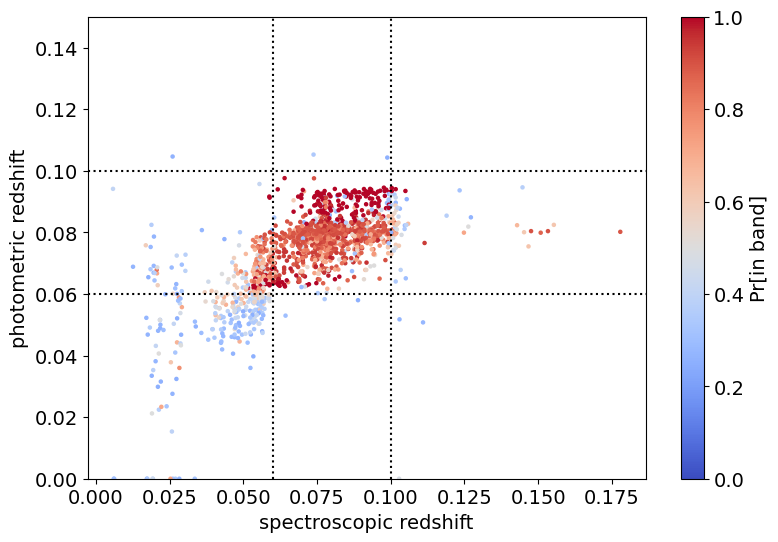

In [49]:
plt.figure(figsize=(9,6))
pband = ms.loc[has_gama_match,'pz1']+ ms.loc[has_gama_match,'pz2']+ ms.loc[has_gama_match,'pz3']+ ms.loc[has_gama_match,'pz4']
plt.scatter(
    gms['Z'],
    ms.loc[has_gama_match, 'z500'],
    c=pband,#gms['logmstar'],
    vmin=0.,
    vmax=1.,
    cmap='coolwarm',
    s=5
)
plt.colorbar(label=r'Pr[in band]')
for ln in [0.06, 0.1]:
    plt.axhline(ln, color='k', ls=':')
    plt.axvline(ln, color='k', ls=':')
#plt.xlim(0.,0.15)
plt.ylim(0.,0.15)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photometric redshift')

In [24]:
bad = (gms['Z']<0.06)|(gms['Z']>0.1)

In [36]:
hathresh = np.logspace(0.5,2,20)
completeness = np.zeros_like(hathresh)
purity = np.zeros_like(hathresh)
for idx, pt in enumerate(hathresh):
    would_be_chosen = gms['HA_EW'] > pt
    purity[idx] = 1. - bad.values[would_be_chosen.values].sum() / would_be_chosen.sum()
    completeness[idx] = (~bad.values)[would_be_chosen.values].sum() / (~bad).sum()

Text(0, 0.5, 'purity')

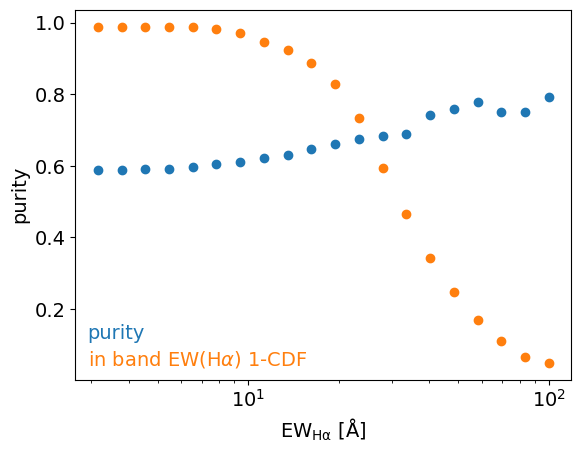

In [39]:

plt.plot(hathresh, purity, 'o')
plt.plot(hathresh, completeness, 'o')
#ek.hist(gms['HA_EW'], cumulative=True,density=True)
ek.text(0.025, 0.1, 'purity', color='C0')
ek.text(0.025, 0.025, r'in band EW(H$\alpha$) 1-CDF', color='C1')
plt.xscale('log')
plt.xlabel(ek.common_labels['haew'])
plt.ylabel('purity')

Text(0.5, 0, '$\\log_{10}({\\rm M}_\\bigstar/[{\\rm M}_\\odot])$')

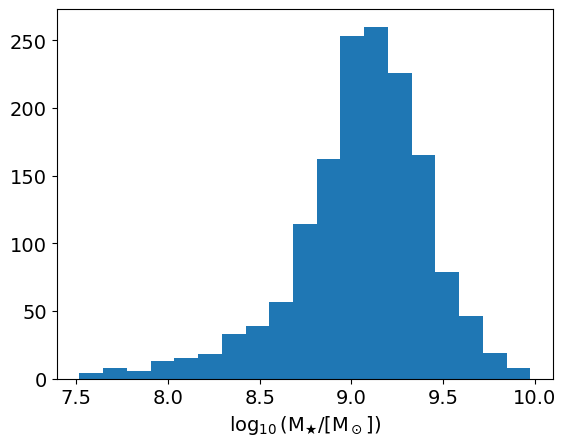

In [58]:
ek.hist(ms.loc[has_gama_match,'logmass'])
plt.xlabel(ek.common_labels['logmstar'])

(-10.5, -8.5)

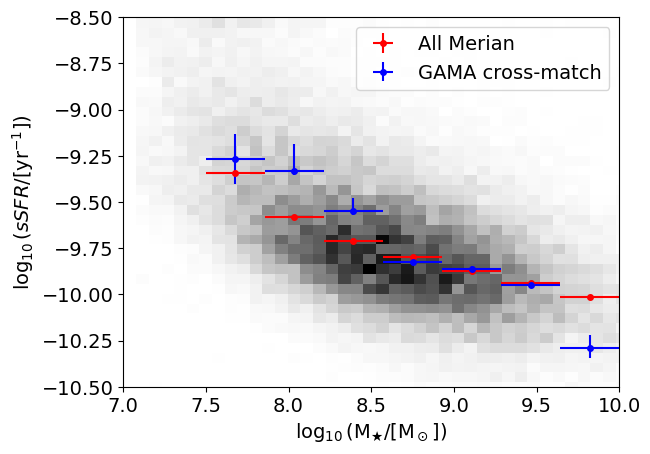

In [88]:
_=ek.hist2d(
    ms.loc[:,'logmass'],
    ms.loc[:,'logssfr'],
    bins=60,
)
ek.running_quantile(
    ms.loc[:,'logmass'],
    ms.loc[:,'logssfr'],
    bins=np.linspace(7.5,10.,8),
    label='All Merian',
    color='r',
    erronqt=True,
    show_std=False
)
ek.running_quantile(
    ms.loc[has_gama_match,'logmass'],
    ms.loc[has_gama_match,'logssfr'],
    bins=np.linspace(7.5,10.,8),
    label='GAMA cross-match',
    color='b',
    erronqt=True,
    show_std=False
)

plt.xlim(7.,10.)
plt.legend()
plt.xlabel(ek.common_labels['logmstar'])
plt.ylabel(ek.convert_label_to_log(ek.common_labels['ssfr']))
plt.ylim(-10.5,-8.5)

Text(0, 0.5, '$\\log_{10}(sSFR/[{\\rm yr}^{-1}])$')

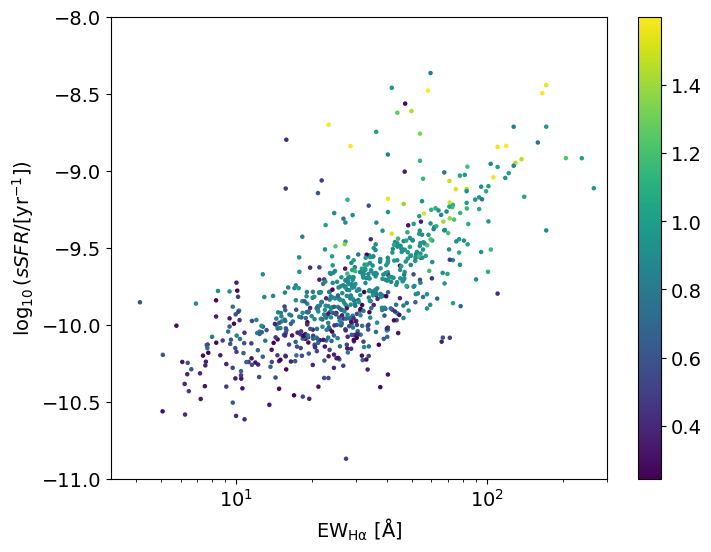

In [436]:
plt.figure(figsize=(8,6))
plt.scatter(
    gms['HA_EW'],
    ms.loc[has_gama_match, 'logssfr'],
    c=pband,
    s=5
)
plt.colorbar()
plt.xlim(10.**0.5, 300)
plt.xscale('log')
plt.ylim(-11.,-8.)
plt.xlabel(ek.common_labels['haew'])
plt.ylabel(ek.convert_label_to_log(ek.common_labels['ssfr']))

In [82]:
sample['z_lit']

M3036112244103474493    0.070300
M3036134234336046425    0.065200
M3036732368661527652         NaN
M3036881902242915835    0.737000
M3037136988940546600    0.061696
M3373367644714451762    0.092333
M3373464401737687979    0.085790
M3373464401737687980    0.085790
M3373741478667887229    0.061663
M3374075730202728056    0.059983
M3455254872704694112    0.086243
M3455268066844233780    0.069384
M3455831016797651494    0.069152
M3456130083960407108         NaN
M3456165268332487016         NaN
M3456539102285930737         NaN
M3459309871587926743         NaN
M3541782039764142828         NaN
M3541848010461821320    0.523726
M3542516513531500127         NaN
M3544631973903380696         NaN
M3545366447670706658    0.072000
Name: z_lit, dtype: float64